In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier # instalado a parte - conda install -c conda-forge py-xgboost
from lightgbm import LGBMClassifier # instalado a parte - conda install -c conda-forge lightgbm


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet201

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import *

import tensorflow.keras as keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import math

import os
from PIL import Image

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Parâmetros

In [3]:
percentege_test_size = 0.2
undersampling_size = -1 # -1 para não fazer undersampling

BATCH_SIZE = 16

# fig preprocessing
# largura = 150
# altura = 150
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

diretorio = './PokemonData/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
# diretorio = '../dados classificacao imagens/pneumonia/'
# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '/home/carlos/Downloads/dados-docs/'
# diretorio = '../dados classificacao imagens/gatos-patos-caes-rapozas-coelhos/treino/'

## Carregando Dataset

In [4]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img) and (not '.svg' in img):
            dados.append([diretorio+classe+'/'+img,classe])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados

image      target
0     ./PokemonData/Hitmonlee/90285d1665ac49babc751c...   Hitmonlee
1     ./PokemonData/Rhydon/5628706d804b4d8e96e8b23f0...      Rhydon
2     ./PokemonData/Diglett/cbf9545edbaf4ff6bd4aa5f4...     Diglett
3     ./PokemonData/Seaking/817601003b444c1397a66d76...     Seaking
4     ./PokemonData/Clefairy/278f59d38ab14e62b8d82bb...    Clefairy
...                                                 ...         ...
6820  ./PokemonData/Ponyta/b3bc58eec6e140b4ac43c0ed0...      Ponyta
6821  ./PokemonData/Weepinbell/f054272a065043a38327f...  Weepinbell
6822  ./PokemonData/Golbat/7460ec7fb2b04cd79449e3fcf...      Golbat
6823  ./PokemonData/Vileplume/c6c97e140df349e0a271bf...   Vileplume
6824  ./PokemonData/Machamp/17fbfac9e5ce4ec3bac143e6...     Machamp

[6825 rows x 2 columns]

## Analisando Dados

In [5]:
print(f'Quantidade de classes totais: {df_dados["target"].nunique()}')
print(f'Quantidade de imagens totais: {df_dados["target"].count()}')
print(f'Média de imagens por classe: {df_dados["target"].value_counts().mean()}')
print(f'Menor quantidade de imagens em uma classe: {df_dados["target"].value_counts().min()}')
print(f'Maior quantidade de imagens em uma classe: {df_dados["target"].value_counts().max()}')

Quantidade de classes totais: 150
Quantidade de imagens totais: 6825
Média de imagens por classe: 45.5
Menor quantidade de imagens em uma classe: 26
Maior quantidade de imagens em uma classe: 66


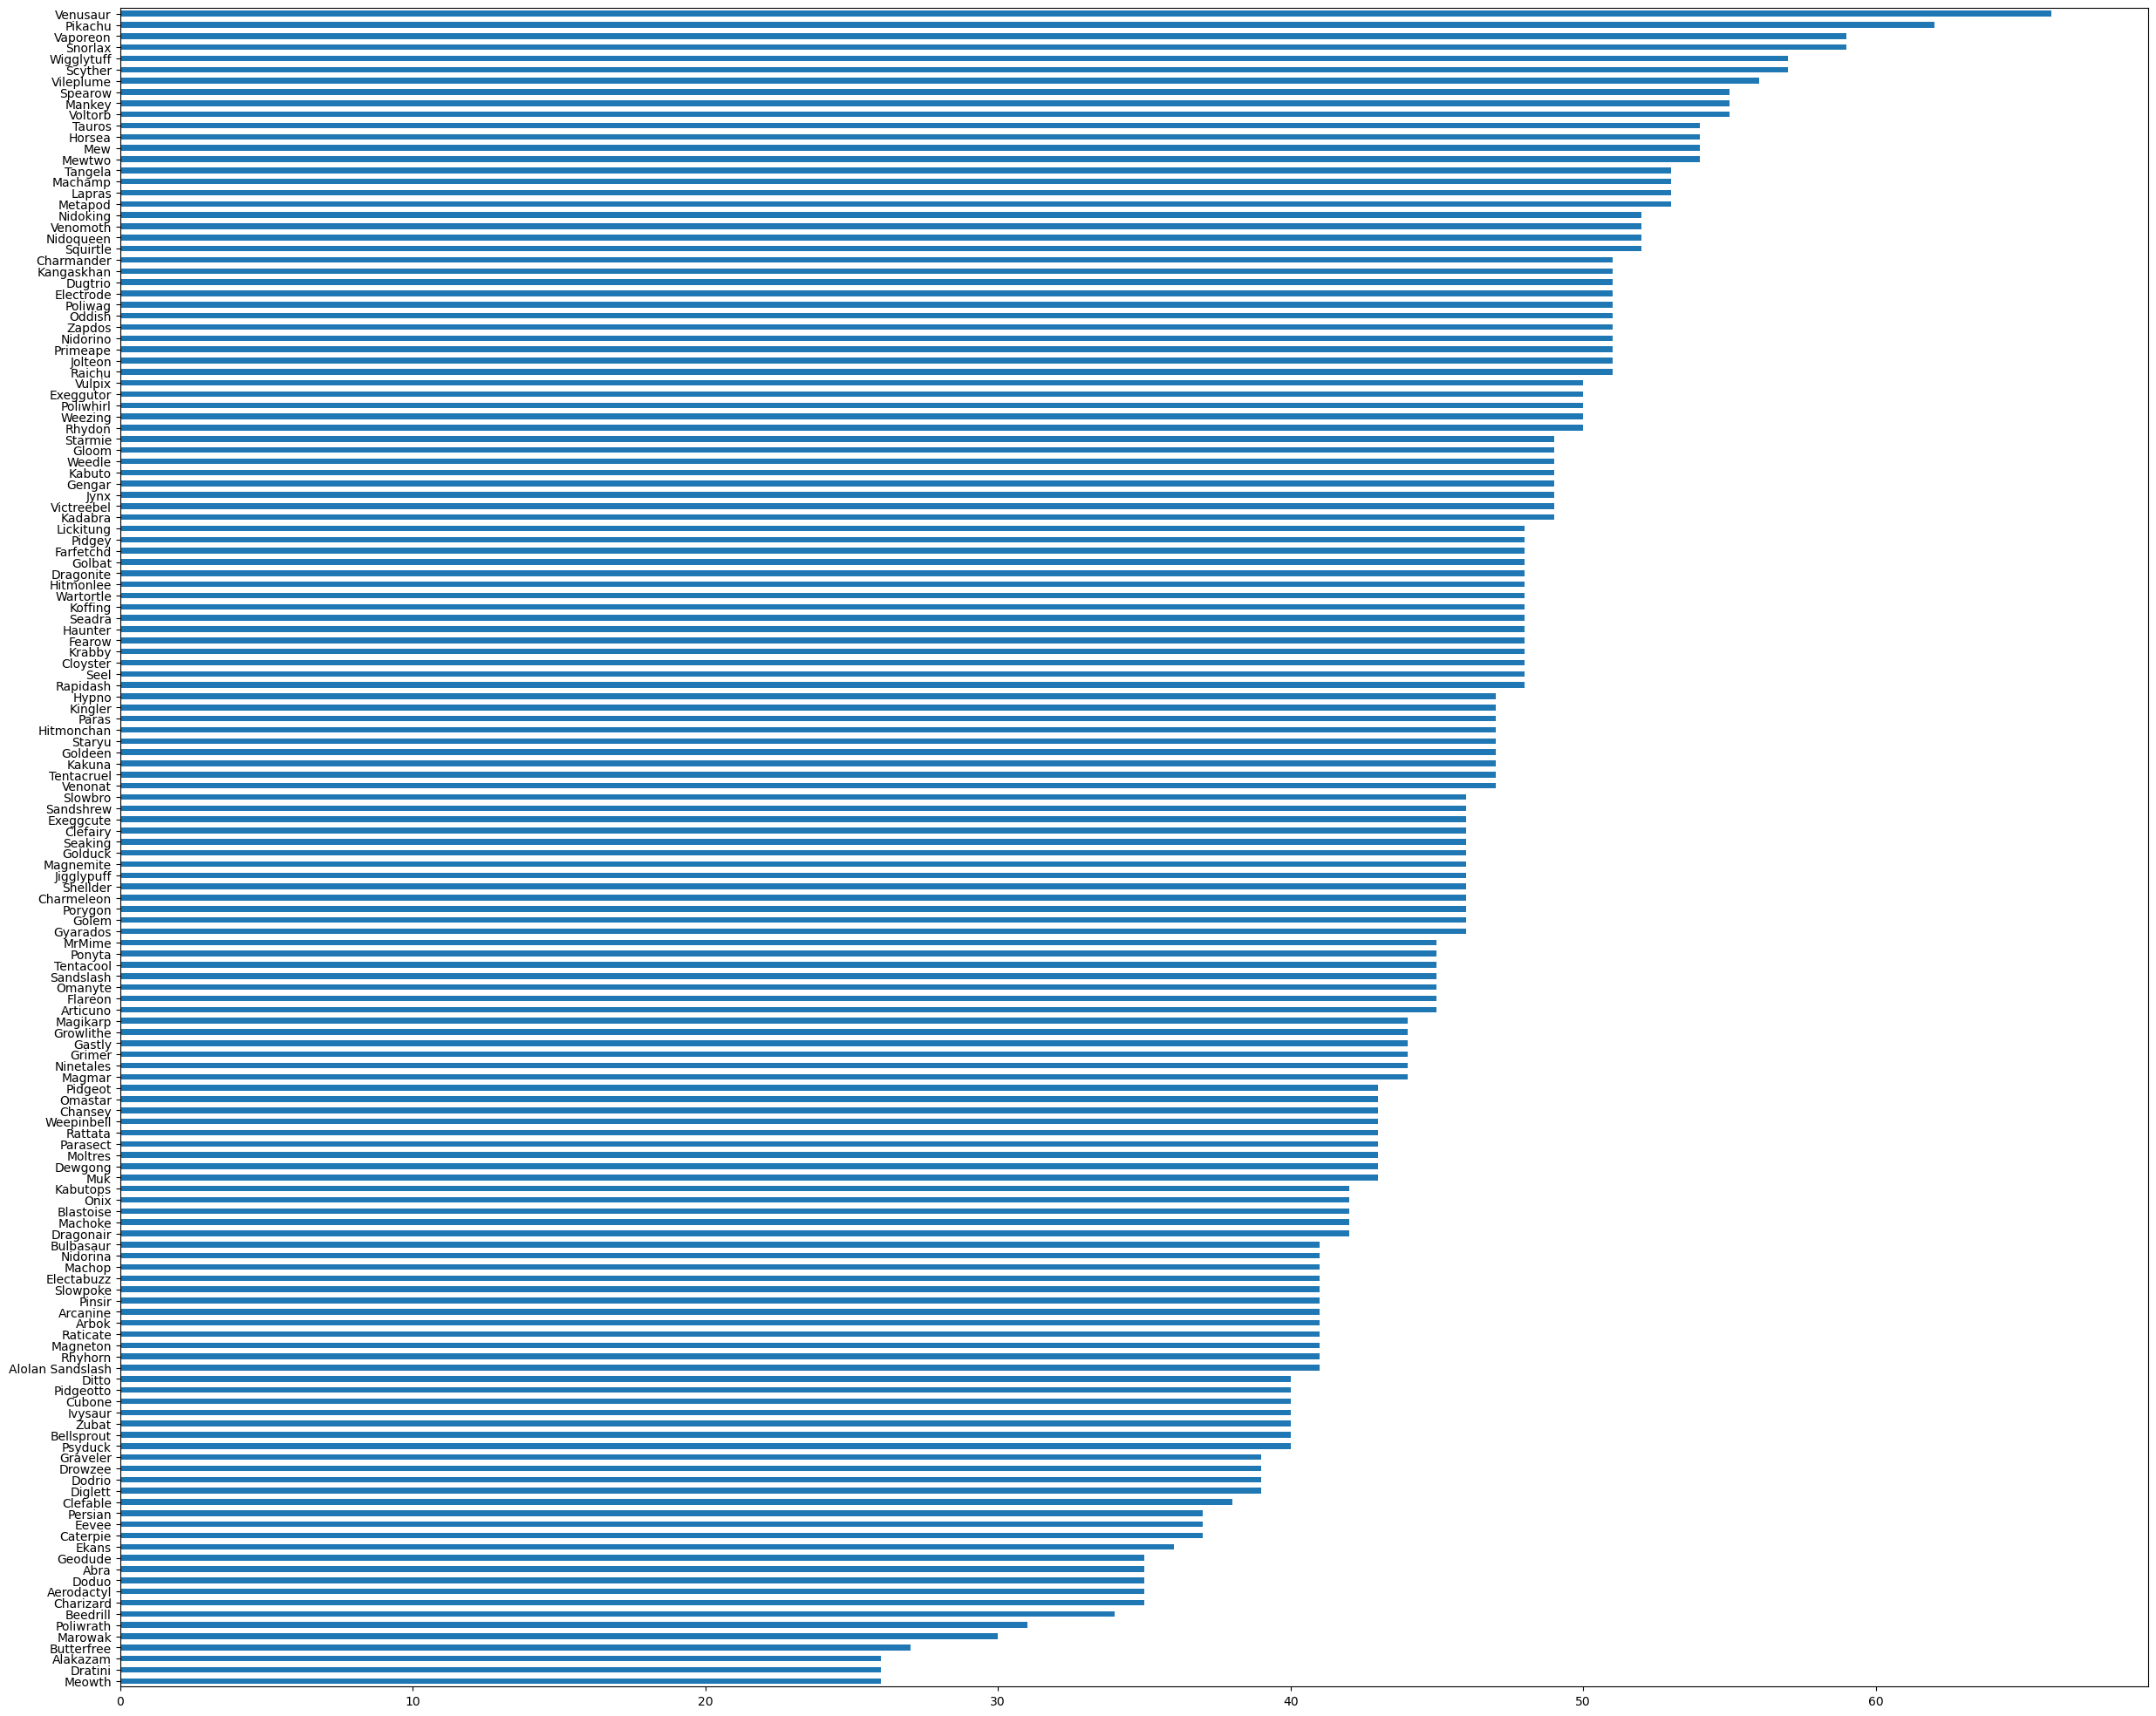

In [6]:
plt.figure(figsize=(30,25))
df_dados['target'].value_counts(ascending=True).plot(kind='barh')

plt.show()

In [7]:
heights = []
widths = []

# iterar através das imagens no diretório
for filename in df_dados['image']:
    # abrir imagem
    img = Image.open(filename)
    # obter dimensões
    width, height = img.size
    # adicionar dimensões à lista
    widths.append(width)
    heights.append(height)

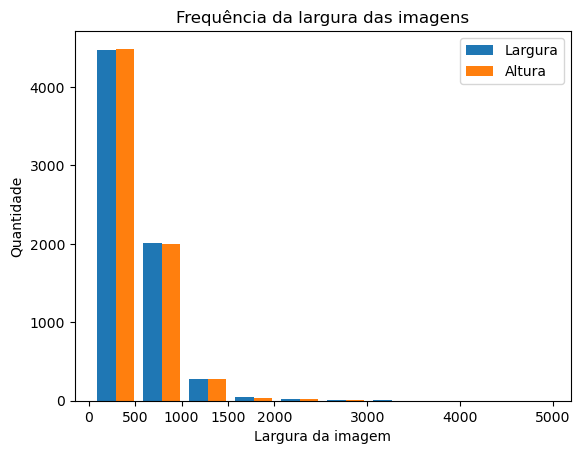

In [8]:
plt.hist([widths, heights])

plt.title("Frequência da largura das imagens")

plt.xlabel("Largura da imagem")
plt.ylabel("Quantidade")

plt.legend(["Largura", "Altura"])

plt.xticks([0, 500, 1000, 1500, 2000, 3000, 4000, 5000])

plt.show()

In [9]:
# calcular tamanho médio
mean_width = sum(w for w in widths) / len(widths)
mean_height = sum(h for h in heights) / len(heights)

print(f"Tamanho médio das imagens em relação a \nwidth: {mean_width} \nheight: {mean_height}")

Tamanho médio das imagens em relação a 
width: 470.407032967033 
height: 466.21758241758243


In [10]:
sorted_widths = sorted(widths)
sorted_heights = sorted(heights)

num_images = len(widths)

if num_images % 2 == 0:
    median_width = (sorted_widths[num_images//2 - 1] + sorted_widths[num_images//2]) / 2
    median_height = (sorted_heights[num_images//2 - 1] + sorted_heights[num_images//2]) / 2
else:
    median_width = sorted_widths[num_images//2]
    median_height = sorted_heights[num_images//2]
    
print(f"Mediana das imagens em relação a \nwidth: {median_width} \nheight: {median_height}")

Mediana das imagens em relação a 
width: 354 
height: 353


In [11]:
print(f"Tamanho da menor imagem em relação a \nwidth: {min(widths)} \nheight: {min(heights)}")

Tamanho da menor imagem em relação a 
width: 43 
height: 42


In [12]:
print(f"Tamanho da maior imagem em relação a \nwidth: {max(widths)} \nheight: {max(heights)}")

Tamanho da maior imagem em relação a 
width: 5000 
height: 4356


In [13]:
largura = math.floor(mean_width)
altura = math.floor(mean_height)

## Gerando mais imagens a partir do dataset

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [15]:
data_images_generator = ImageDataGenerator(rescale=1./255, # rescalar
                                            rotation_range=40, # rotacionar imagem
                                            width_shift_range=0.2, # deslocamento horizontal
                                            height_shift_range=0.2, # deslocamento vertical
                                            shear_range=0.2, # cisalhamento
                                            zoom_range=0.2, # zoom
                                            horizontal_flip=True, # inverter horizontalmente
                                            fill_mode='nearest')

In [16]:
#data_gen = data_images_generator.flow_from_directory(batch_size=BATCH_SIZE,
#                                                     directory=diretorio,
#                                                     shuffle=True,
#                                                     target_size=(largura,altura))

data_gen = data_images_generator.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=True,
                                                     target_size=(largura,altura))

Found 6820 validated image filenames belonging to 150 classes.


C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [17]:
data_gen.class_indices

{'Abra': 0,
 'Aerodactyl': 1,
 'Alakazam': 2,
 'Alolan Sandslash': 3,
 'Arbok': 4,
 'Arcanine': 5,
 'Articuno': 6,
 'Beedrill': 7,
 'Bellsprout': 8,
 'Blastoise': 9,
 'Bulbasaur': 10,
 'Butterfree': 11,
 'Caterpie': 12,
 'Chansey': 13,
 'Charizard': 14,
 'Charmander': 15,
 'Charmeleon': 16,
 'Clefable': 17,
 'Clefairy': 18,
 'Cloyster': 19,
 'Cubone': 20,
 'Dewgong': 21,
 'Diglett': 22,
 'Ditto': 23,
 'Dodrio': 24,
 'Doduo': 25,
 'Dragonair': 26,
 'Dragonite': 27,
 'Dratini': 28,
 'Drowzee': 29,
 'Dugtrio': 30,
 'Eevee': 31,
 'Ekans': 32,
 'Electabuzz': 33,
 'Electrode': 34,
 'Exeggcute': 35,
 'Exeggutor': 36,
 'Farfetchd': 37,
 'Fearow': 38,
 'Flareon': 39,
 'Gastly': 40,
 'Gengar': 41,
 'Geodude': 42,
 'Gloom': 43,
 'Golbat': 44,
 'Goldeen': 45,
 'Golduck': 46,
 'Golem': 47,
 'Graveler': 48,
 'Grimer': 49,
 'Growlithe': 50,
 'Gyarados': 51,
 'Haunter': 52,
 'Hitmonchan': 53,
 'Hitmonlee': 54,
 'Horsea': 55,
 'Hypno': 56,
 'Ivysaur': 57,
 'Jigglypuff': 58,
 'Jolteon': 59,
 'Jynx': 60,

In [18]:
data_gen.samples

6820

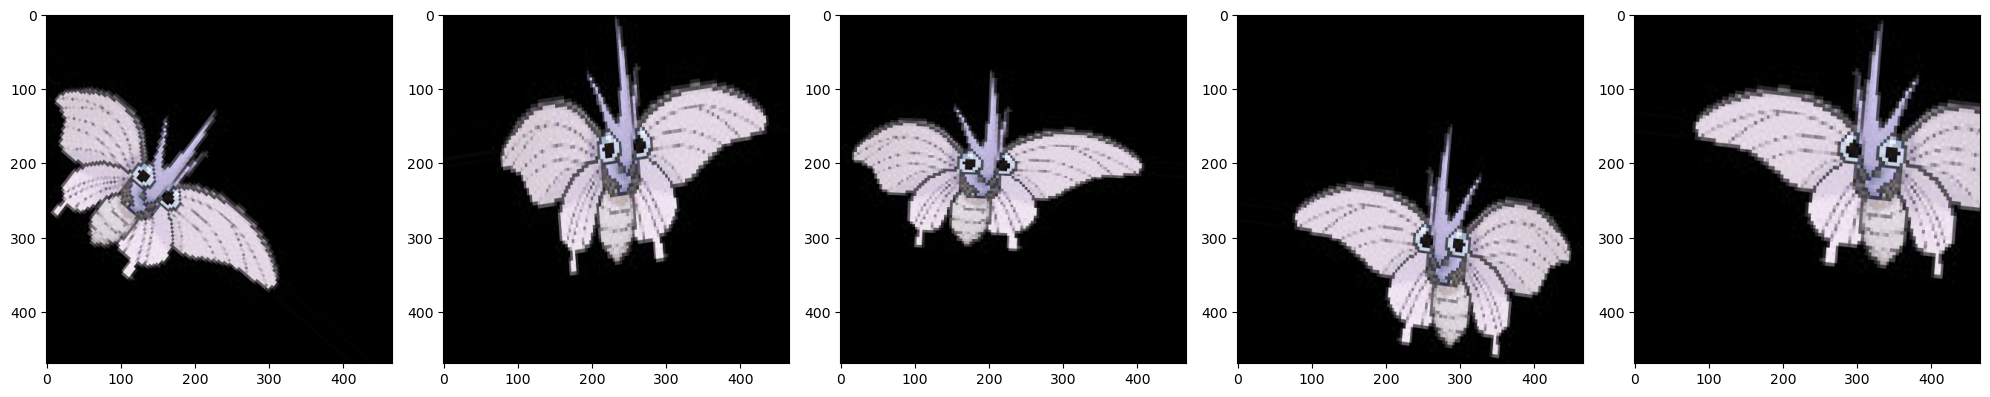

In [19]:
images = [data_gen[0][0][8] for i in range(5)]
plotImages(images)

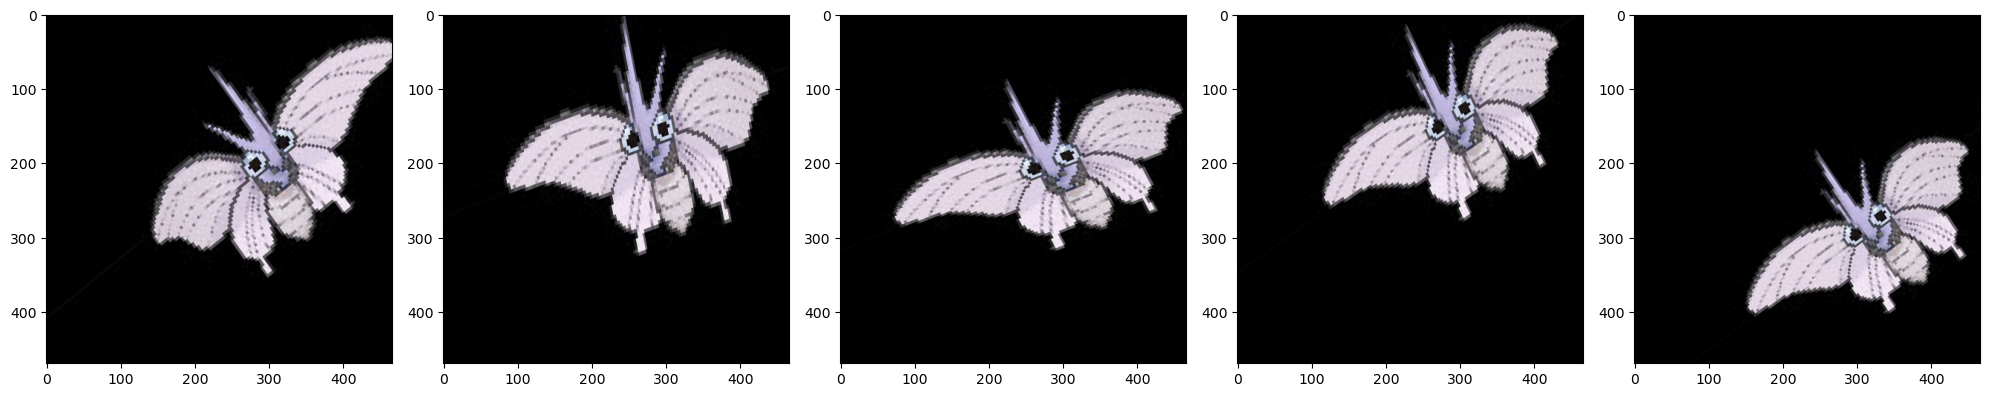

In [20]:
images = [data_gen[0][0][8] for i in range(465, 470)]
plotImages(images)

## Preparando Dados

In [21]:
def getEmbedder():
    # return EfficientNetB0(weights='imagenet', include_top=False)
    # return EfficientNetB2(weights='imagenet', include_top=False)
    # return EfficientNetB3(weights='imagenet', include_top=False)
    # return EfficientNetB4(weights='imagenet', include_top=False)
    # return EfficientNetB7(weights='imagenet', include_top=False)
    # return InceptionV3(weights='imagenet', include_top=False)
    return Xception(weights='imagenet', include_top=False)
    # return DenseNet201(weights='imagenet', include_top=False)

def embedding(embedder, img_path, largura, altura, modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    embed = np.expand_dims(embed, axis=0)
        # embed = preprocess_input(embed)

    features = embedder.predict(embed)

    return features[0][0][0]

def embeddingTest(embedder, img_path, largura, altura, modo_de_cor, n_transformations):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    
    array_img_transformed = []
    
    # FAZER NA IMAGEM ORINAL SEM MUDAR NADA
    img_transformed = image.img_to_array(img)

    embed = np.expand_dims(img_transformed, axis=0)
    # embed = preprocess_input(embed)

    features = embedder.predict(embed)
    
    array_img_transformed.append(features[0][0][0])
        
    for _ in range(n_transformations):
        
        img_transformed = data_images_generator.random_transform(image.img_to_array(img))

        embed = np.expand_dims(img_transformed, axis=0)
            # embed = preprocess_input(embed)

        features = embedder.predict(embed)
        
        array_img_transformed.append(features[0][0][0])

    return np.array(array_img_transformed)

def embeddingWithoutModel(img_path, largura, altura, modo_de_cor):
    
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    
    shape_entrada = largura*altura*1

    if(modo_de_cor == 'rgb'):
        shape_entrada = largura*altura*3

    if(modo_de_cor == 'rgba'):
        shape_entrada = largura*altura*4
    
    return embed.reshape(shape_entrada)

embedder = getEmbedder()

In [22]:
#tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [23]:
target = df_dados['target'].array
n_transformations = 2

array_features = []
for x in dados:
    #array_features.append(embedding(embedder, x[0], largura, altura, modo_de_cor))
    array_features.extend(embeddingTest(embedder, x[0], largura, altura, modo_de_cor, n_transformations))
    # array_features.append(embeddingWithoutModel(x[0], largura, altura, modo_de_cor))

scaler = preprocessing.StandardScaler()

# array_features = np.array(array_features, dtype=np.uint8)

array_features = scaler.fit_transform(array_features)

df_features = pd.DataFrame(array_features)

df_features

1/1 [==============================] - 0s 55ms/step


0         1         2         3         4        5         6     \
0     -0.006989  1.238117 -0.366400 -0.006989 -0.022817 -0.12561 -0.126914   
1     -0.006989  0.356931 -0.366400 -0.006989 -0.022817 -0.12561  0.099989   
2     -0.006989  1.127114  1.530392 -0.006989 -0.022817 -0.12561 -0.404251   
3     -0.006989  0.996240  4.466250 -0.006989 -0.022817 -0.12561 -0.727515   
4     -0.006989  1.556188 -0.366400 -0.006989 -0.022817 -0.12561  2.150446   
...         ...       ...       ...       ...       ...      ...       ...   
20470 -0.006989 -0.270642 -0.366400 -0.006989 -0.022817 -0.12561 -0.288116   
20471 -0.006989 -0.967162  2.355449 -0.006989 -0.022817 -0.12561 -0.727515   
20472 -0.006989  1.573572 -0.366400 -0.006989 -0.022817 -0.12561  0.405876   
20473 -0.006989 -0.046361 -0.366400 -0.006989 -0.022817 -0.12561 -0.727515   
20474 -0.006989 -0.967162 -0.366400 -0.006989 -0.022817 -0.12561  0.690169   

           7         8         9     ...      2038      2039      2040  \
0     -0.017501 -0.278587 -0.025387  ... -0.017717 -0.089465 -0.261447   
1     -0.017501 -0.278587 -0.025387  ... -0.017717 -0.089465 -0.261447   
2     -0.017501 -0.278587 -0.025387  ... -0.017717 -0.089465 -0.261447   
3     -0.017501 -0.278587 -0.025387  ... -0.017717 -0.089465 -0.261447   
4     -0.017501 -0.278587 -0.025387  ... -0.017717 -0.089465 -0.261447   
...         ...       ...       ...  ...       ...       ...       ...   
20470 -0.017501 -0.278587 -0.025387  ... -0.017717 -0.089465 -0.261447   
20471 -0.017501  9.041178 -0.025387  ... -0.017717 -0.089465  8.644948   
20472 -0.017501 -0.278587 -0.025387  ... -0.017717 -0.089465 -0.261447   
20473 -0.017501 -0.278587 -0.025387  ... -0.017717 -0.089465 -0.261447   
20474 -0.017501 -0.278587 -0.025387  ... -0.017717 -0.089465 -0.261447   

           2041  2042      2043      2044      2045      2046      2047  
0     -0.006989   0.0 -0.207187 -0.018321 -0.012772  0.523902 -0.015607  
1     -0.006989   0.0 -0.207187 -0.018321 -0.012772  0.449168 -0.015607  
2     -0.006989   0.0 -0.207187 -0.018321 -0.012772  2.955276 -0.015607  
3     -0.006989   0.0 -0.207187 -0.018321 -0.012772  2.200002 -0.015607  
4     -0.006989   0.0 -0.207187 -0.018321 -0.012772  2.652396 -0.015607  
...         ...   ...       ...       ...       ...       ...       ...  
20470 -0.006989   0.0 -0.207187 -0.018321 -0.012772  1.258909 -0.015607  
20471 -0.006989   0.0 -0.207187 -0.018321 -0.012772  0.141842 -0.015607  
20472 -0.006989   0.0 -0.207187 -0.018321 -0.012772  0.622919 -0.015607  
20473 -0.006989   0.0 -0.207187 -0.018321 -0.012772 -0.759436 -0.015607  
20474 -0.006989   0.0 -0.207187 -0.018321 -0.012772 -0.759436 -0.015607  

[20475 rows x 2048 columns]

In [24]:
target_transformation = np.repeat(target, n_transformations + 1) # imagens transformadas + a original

target_transformation

<PandasArray>
[  'Machop',   'Machop',   'Machop',    'Zubat',    'Zubat',    'Zubat',
  'Koffing',  'Koffing',  'Koffing',  'Machamp',
 ...
 'Kabutops',   'Rhydon',   'Rhydon',   'Rhydon',   'Zapdos',   'Zapdos',
   'Zapdos',   'Ponyta',   'Ponyta',   'Ponyta']
Length: 20475, dtype: object

## Reduzindo a Dimensionalidade

In [25]:
model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50)
array_red = model.fit_transform(df_features) 

df_tsne = pd.DataFrame(array_red)

df_tsne['target'] = target_transformation

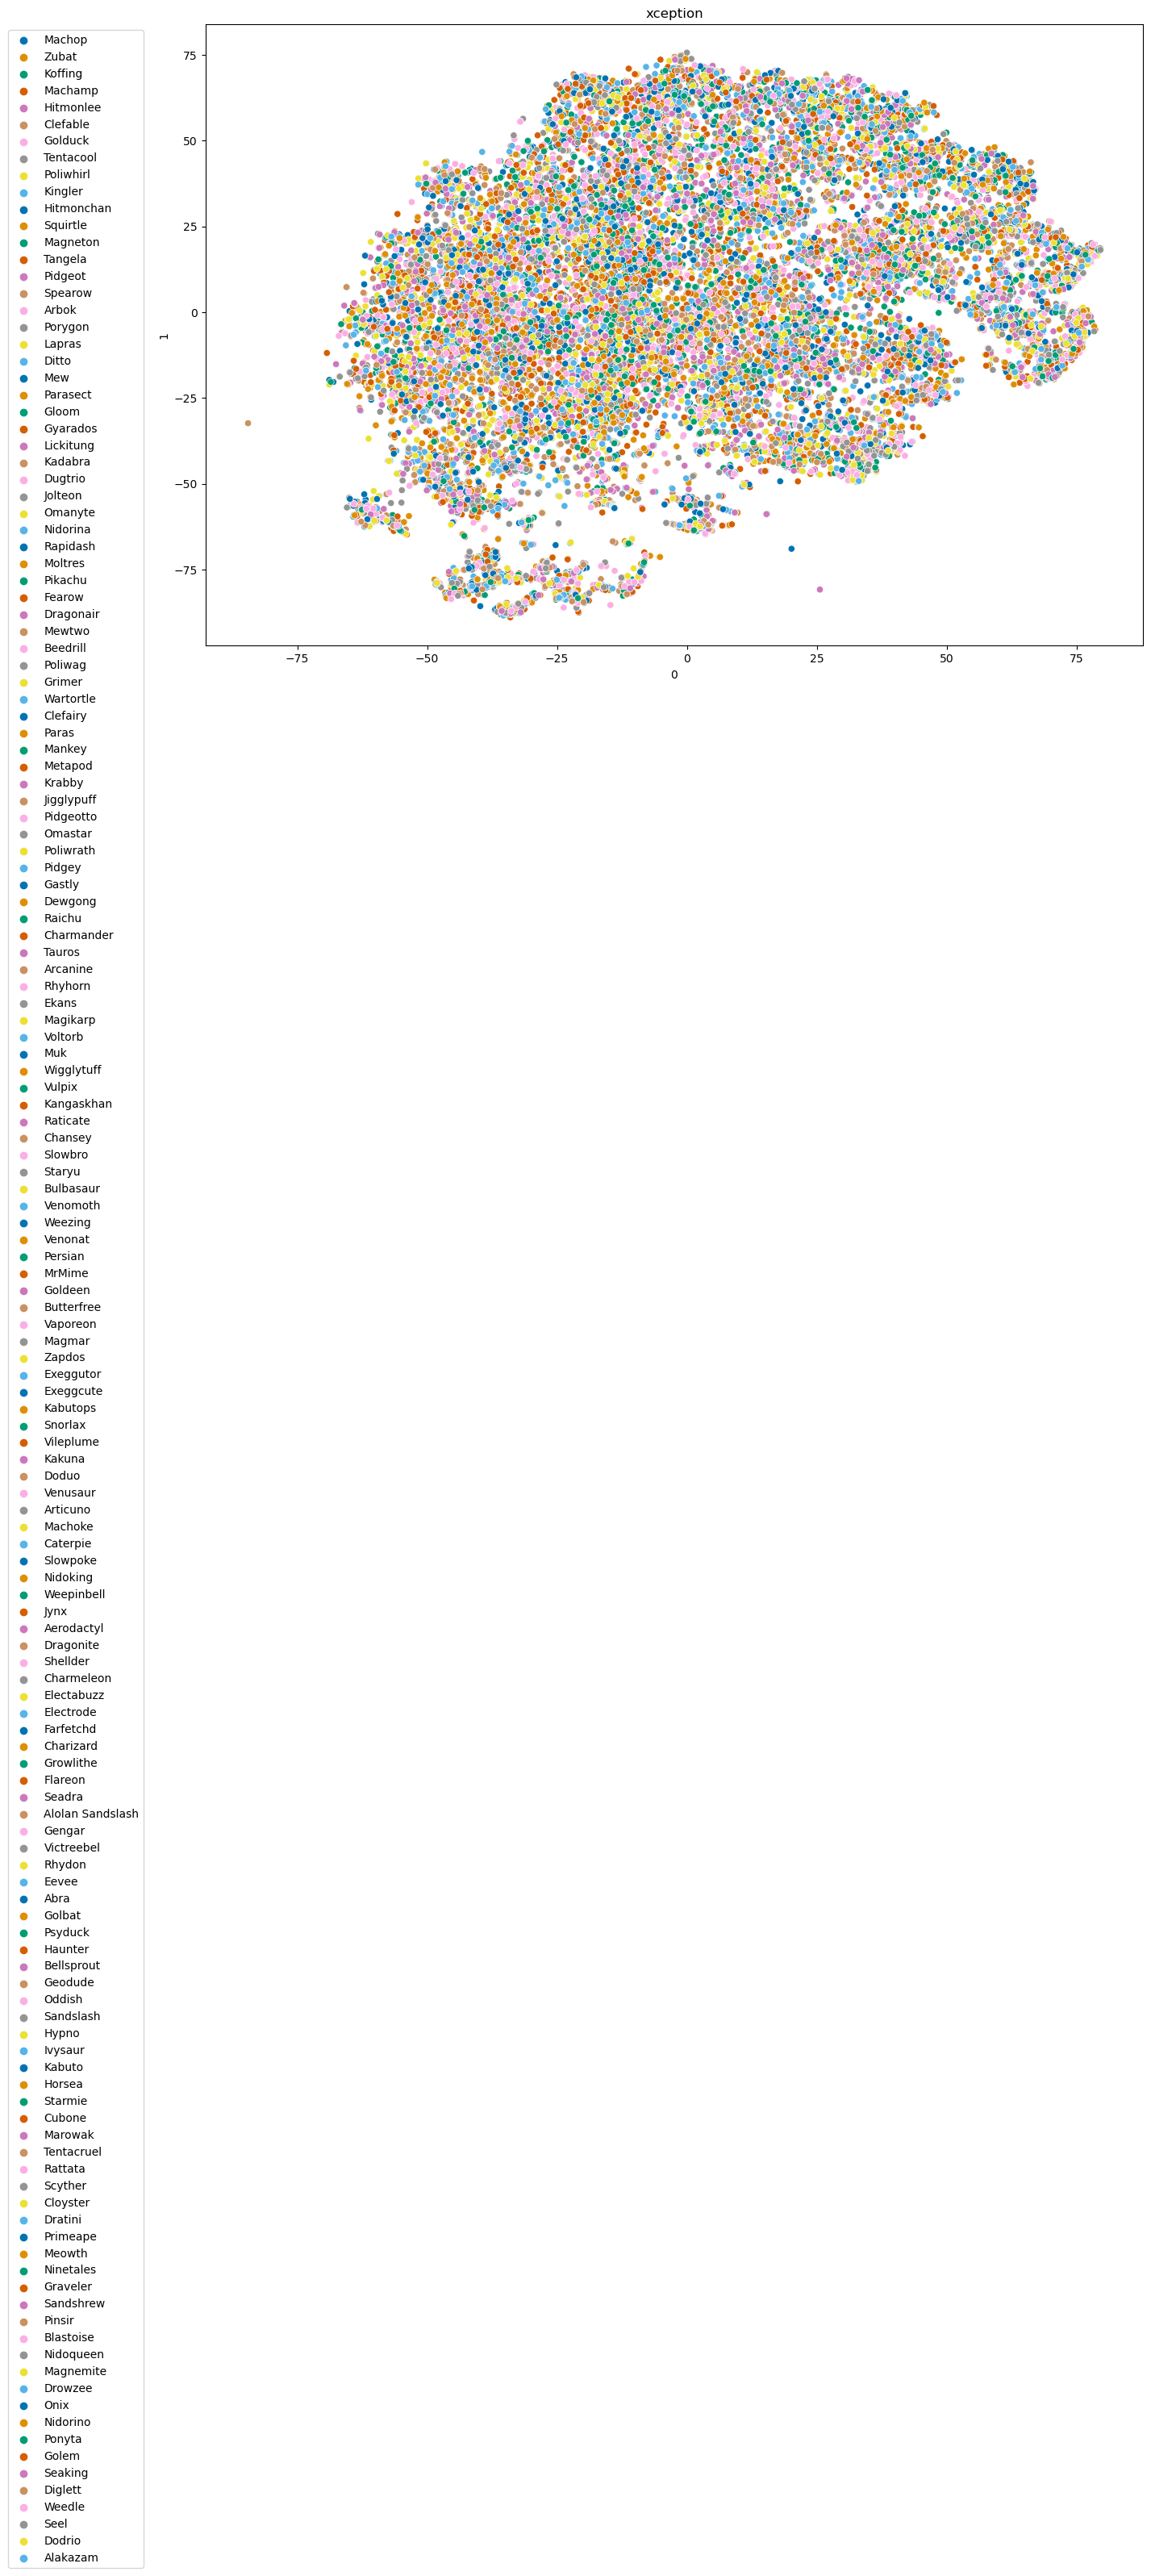

In [26]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne, x=df_tsne[0], y=df_tsne[1], hue=df_tsne['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title(getEmbedder().name)

plt.savefig(f"Embedding {getEmbedder().name}", bbox_inches="tight")

plt.show()

## Mostrando só algumas classes da redução de dimensionalidade

In [27]:
ten_classes = df_tsne['target'].unique()[0:10]

ten_classes

array(['Machop', 'Zubat', 'Koffing', 'Machamp', 'Hitmonlee', 'Clefable',
       'Golduck', 'Tentacool', 'Poliwhirl', 'Kingler'], dtype=object)

In [28]:
df_tsne_filter_by_ten_classes = df_tsne[df_tsne['target'].isin(ten_classes)]

df_tsne_filter_by_ten_classes.head()

0          1  target
0  67.255768   8.138127  Machop
1  73.414764  11.009907  Machop
2 -26.070137  53.823483  Machop
3 -19.712660  67.253159   Zubat
4  19.320114  63.520382   Zubat

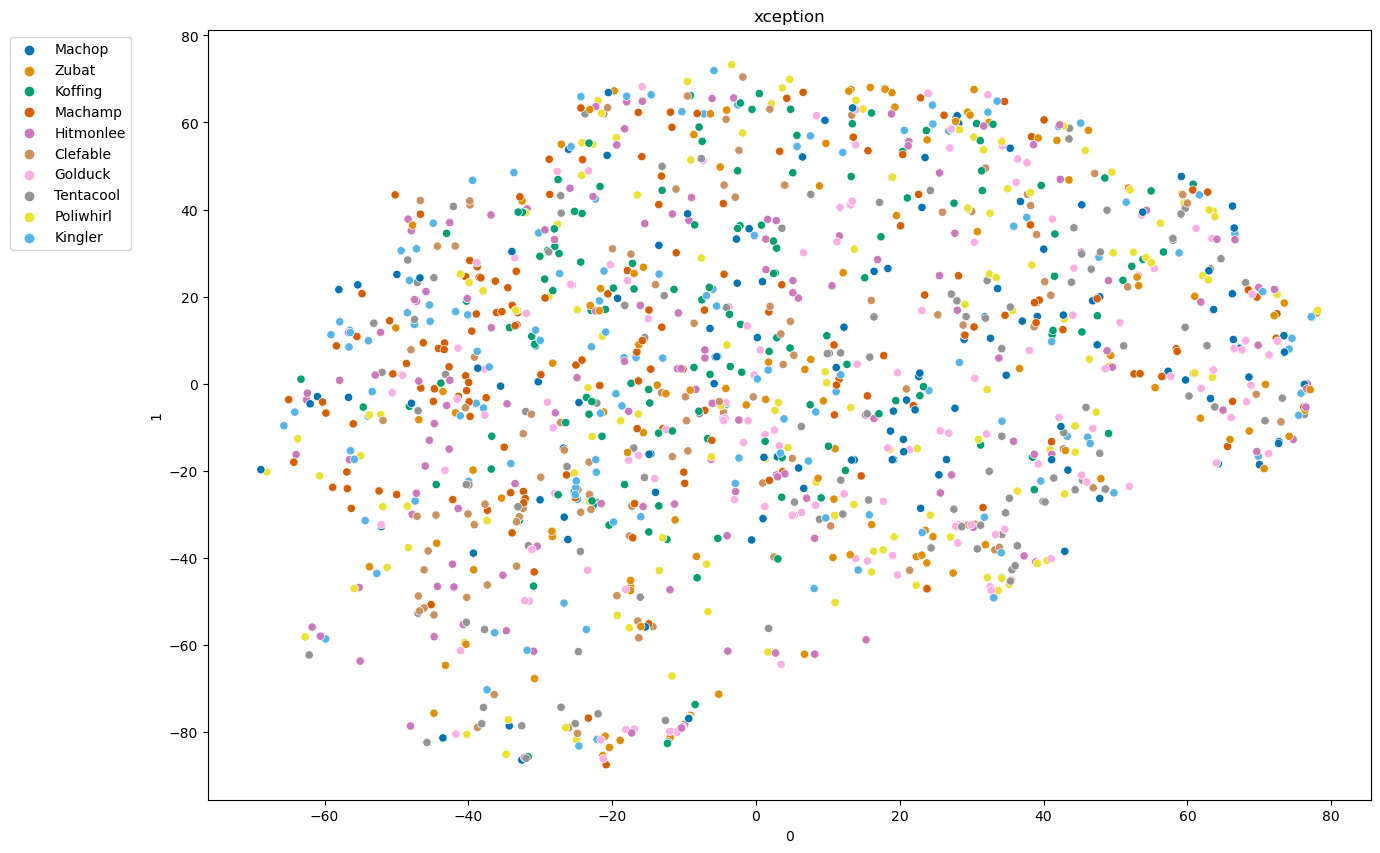

In [29]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne_filter_by_ten_classes, x=df_tsne_filter_by_ten_classes[0], y=df_tsne_filter_by_ten_classes[1], hue=df_tsne_filter_by_ten_classes['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title(getEmbedder().name)

plt.savefig(f"Embedding {getEmbedder().name} - Filtered by 10 Classes", bbox_inches="tight")

plt.show()

## Treinando e Validando o Modelo

In [30]:
def getModel():
    # Ensemble
    return RandomForestClassifier(n_jobs=12)
    # return AdaBoostClassifier()

    # Linear
    # return LogisticRegression(n_jobs=-1)#n_jobs=12, solver='sag', multi_class='ovr')
    # return SGDClassifier(n_jobs=12,early_stopping=True,validation_fraction=0.05)

    # Tree
    # return DecisionTreeClassifier()
    
    # Neighbors
    # return KNeighborsClassifier(n_neighbors=3,n_jobs=12)
    
    # Support Vector Machines - SVM
    # return SVC()
    
    # Instalados a parte
    # return XGBClassifier()
    # return LGBMClassifier(n_jobs=-1) # - mais leve que o XGB

In [119]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values,target_transformation,test_size=percentege_test_size)

model = getModel().fit(X_treino, y_treino)

score = model.score(X_teste, y_teste)

score

0.042002442002442006

## Validando

In [31]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(getModel(),df_features.values,target_transformation,cv=cv,scoring=scoring)

scores

{'fit_time': array([36.64862633, 33.68099952, 34.13596153, 32.67638135, 33.39399934]),
 'score_time': array([0.94962335, 1.04100156, 0.99900222, 1.23700047, 0.81603813]),
 'test_accuracy': array([0.03858364, 0.03931624, 0.03809524, 0.03809524, 0.04395604]),
 'test_precision': array([0.03767774, 0.04051258, 0.03851907, 0.03761918, 0.043693  ]),
 'test_recall': array([0.03858364, 0.03931624, 0.03809524, 0.03809524, 0.04395604]),
 'test_f1': array([0.03670732, 0.03869759, 0.0367025 , 0.03684442, 0.042409  ])}

In [33]:
print('Acurácia média:', scores['test_accuracy'].mean())
print('Precisão média:', scores['test_precision'].mean())
print('Recall médio:', scores['test_recall'].mean())
print('F1 médio:', scores['test_f1'].mean())

Acurácia média: 0.03960927960927961
Precisão média: 0.039604311644413234
Recall médio: 0.03960927960927961
F1 médio: 0.038272165755103074


scores = cross_val_score(getModel(),df_features.values,target_transformation,cv=5)

np.mean(scores)

## Visualizando Matriz de Confusão

predicoes = cross_val_predict(getModel(),df_features.values,target,cv=5)

cm = confusion_matrix(target, predicoes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()

## Usando Redes neurais com "transfer learning"

In [21]:
data_images_generator_train = ImageDataGenerator(rescale=1./255, # rescalar
                                            rotation_range=40, # rotacionar imagem
                                            width_shift_range=0.2, # deslocamento horizontal
                                            height_shift_range=0.2, # deslocamento vertical
                                            shear_range=0.2, # cisalhamento
                                            zoom_range=0.2, # zoom
                                            horizontal_flip=True, # inverter horizontalmente
                                            fill_mode='nearest')

data_images_generator_test = ImageDataGenerator(rescale=1./255)

In [22]:
x_train_balanced, x_val_balanced, y_train_balanced, y_val_balanced = train_test_split(df_dados['image'], df_dados['target'], test_size=0.25, stratify=df_dados['target'])


In [23]:
print(f'{len(x_train_balanced)} + {len(x_val_balanced)} = {len(x_train_balanced) + len(x_val_balanced)}')

5118 + 1707 = 6825


In [24]:
print(f'{len(y_train_balanced)} + {len(y_val_balanced)} = {len(y_train_balanced) + len(y_val_balanced)}')

5118 + 1707 = 6825


In [25]:
df_dados_train = pd.DataFrame({'image': x_train_balanced, 'target': y_train_balanced})

df_dados_train

image      target
5650  ./PokemonData/Tangela/472d6c241dd24e2e833ad00c...     Tangela
3071  ./PokemonData/Blastoise/9b2670dc4f314091bd061d...   Blastoise
5873  ./PokemonData/Jolteon/474cf8c650c4420f91d34475...     Jolteon
175   ./PokemonData/Blastoise/ca322048577b4cc6a46e66...   Blastoise
1336  ./PokemonData/Weepinbell/9c7753f4e1dd46719826b...  Weepinbell
...                                                 ...         ...
2538  ./PokemonData/Venusaur/2f46340d214f481cbac4648...    Venusaur
6195  ./PokemonData/Porygon/e491bfcae5ab4e728867d7ea...     Porygon
305   ./PokemonData/Flareon/00dc17c679354abb97ee2927...     Flareon
1556  ./PokemonData/Farfetchd/4428f52e6603460f826f39...   Farfetchd
3123  ./PokemonData/Zubat/2f2b500ea2e24618aa5fe6f1ad...       Zubat

[5118 rows x 2 columns]

In [26]:
df_dados_test= pd.DataFrame({'image': x_val_balanced, 'target': y_val_balanced})

df_dados_test

image      target
3791  ./PokemonData/Rapidash/a2f57bde298e434e912dfe9...    Rapidash
925   ./PokemonData/Goldeen/1f4b85d4a8c14c55bf7f13fd...     Goldeen
80    ./PokemonData/Cubone/765c723986e24611898957827...      Cubone
4988  ./PokemonData/Cubone/98bbe7e31b05495faa3e97276...      Cubone
5899  ./PokemonData/Dugtrio/920399ada1084592a2a0c15c...     Dugtrio
...                                                 ...         ...
1431  ./PokemonData/Marowak/0e1dfaed38cc4dd893607ba5...     Marowak
1693  ./PokemonData/Shellder/7067c6ba6aab45fc9546417...    Shellder
6168  ./PokemonData/Kadabra/28121f963a8e4d9cb86b5a24...     Kadabra
4307  ./PokemonData/Kangaskhan/b6a812f0bb7c452ba4368...  Kangaskhan
4708  ./PokemonData/Venomoth/23e845e9c90041c88ffc59d...    Venomoth

[1707 rows x 2 columns]

In [27]:
data_gen_train = data_images_generator_train.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados_train,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=True,
                                                     target_size=(largura,altura))

data_gen_test= data_images_generator_test.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados_test,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=False,
                                                     target_size=(largura,altura))


Found 5117 validated image filenames belonging to 150 classes.
Found 1703 validated image filenames belonging to 150 classes.


C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 4 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


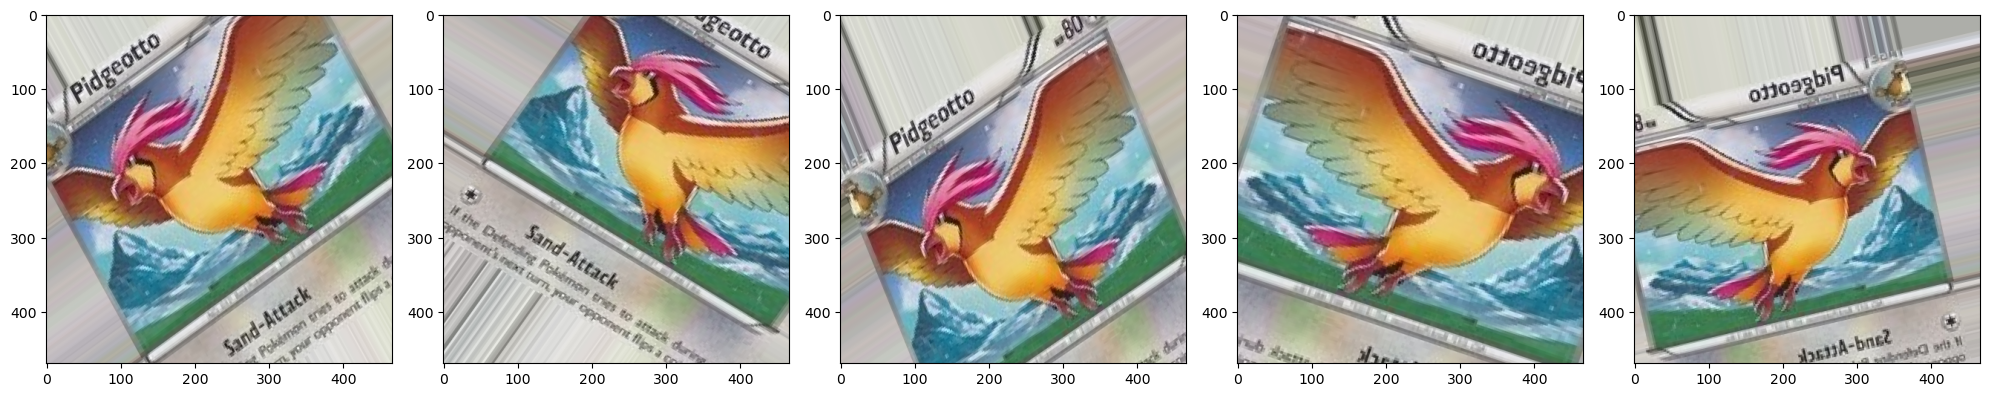

In [28]:
images = [data_gen_train[0][0][8] for i in range(5)]
plotImages(images)

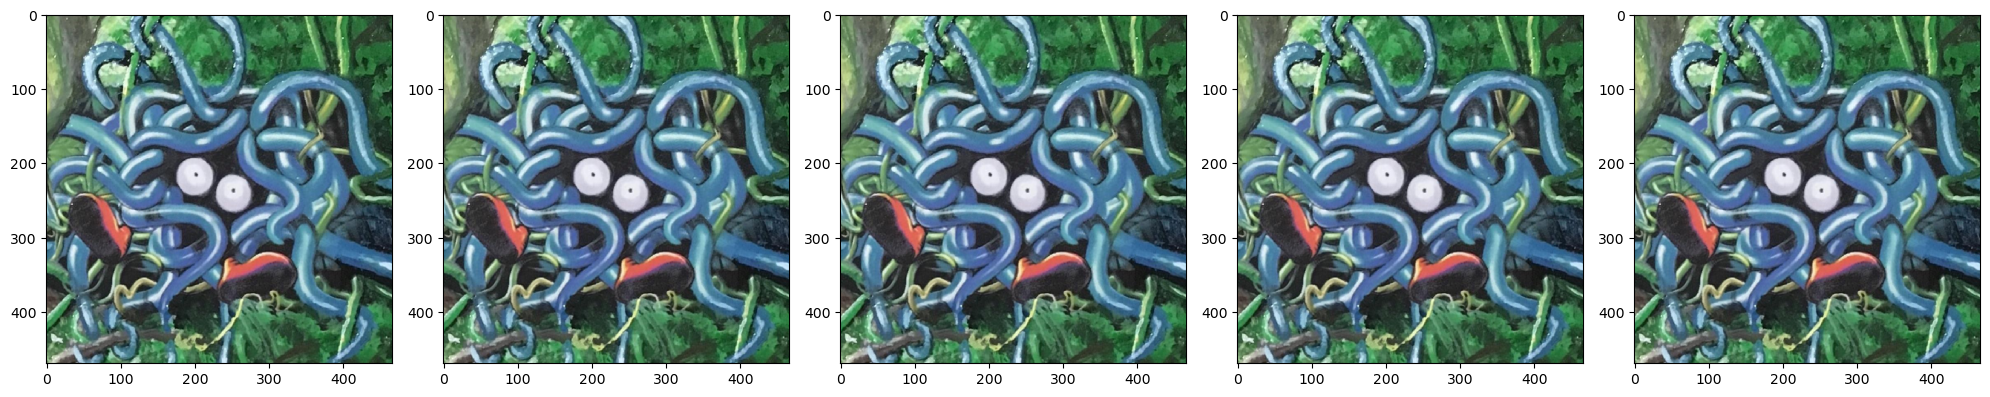

In [29]:
images = [data_gen_test[0][0][8] for i in range(5)]
plotImages(images)

In [30]:
conv_base = keras.applications.Xception(weights='imagenet', include_top=False,
                  input_shape=(largura,altura,3))
conv_base.trainable = False

In [31]:
my_init = keras.initializers.glorot_uniform(seed = 1)
model = keras.models.Sequential([
    conv_base,
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    
    keras.layers.Dropout(0.2),

    keras.layers.Dense(1024, activation='relu', kernel_initializer = my_init, kernel_regularizer=regularizers.l2(0.001)), # regularizer - evitar overfitting
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(512, activation='relu', kernel_initializer = my_init, kernel_regularizer=regularizers.l2(0.001)), # regularizer - evitar overfitting
    keras.layers.BatchNormalization(),

    keras.layers.Dense(150, activation='softmax', kernel_initializer = my_init)
                         
])

In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 15, 15, 2048)      20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 15, 15, 2048)     8192      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4

In [34]:
EPOCHS = 25

In [35]:
callbacks = [
    ModelCheckpoint("PokemonClassification.h5", save_best_only=True),
    EarlyStopping(monitor="val_accuracy", mode='max', patience=6), ## interrompe se nao houver melhora apos um numero de epocas definidas
    ReduceLROnPlateau(monitor="val_accuracy",factor=0.1,patience=4) ## nao melhora apos um numero de epocas definidas
]

In [36]:
history = model.fit(
            data_gen_train,
            steps_per_epoch=math.ceil(len(data_gen_train) / BATCH_SIZE),
            epochs=EPOCHS,
            validation_data=data_gen_test,
            validation_steps=math.ceil(len(data_gen_test) / BATCH_SIZE),
            #callbacks=callbacks
          )

Epoch 1/25
20/20 [==============================] - 30s 1s/step - loss: 7.4089 - accuracy: 0.0562 - precision: 0.6667 - recall: 0.0063 - auc: 0.5814 - val_loss: 6.9940 - val_accuracy: 0.0357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5923
Epoch 2/25
20/20 [==============================] - 21s 1s/step - loss: 6.6673 - accuracy: 0.1312 - precision: 0.4783 - recall: 0.0344 - auc: 0.7189 - val_loss: 6.9189 - val_accuracy: 0.0804 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6729
Epoch 3/25
20/20 [==============================] - 21s 1s/step - loss: 6.5365 - accuracy: 0.1375 - precision: 0.5000 - recall: 0.0406 - auc: 0.7371 - val_loss: 6.7648 - val_accuracy: 0.0804 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7323
Epoch 4/25
20/20 [==============================] - 22s 1s/step - loss: 6.0367 - accuracy: 0.1969 - precision: 0.5938 - recall: 0.0594 - auc: 0.8116 - val_loss: 6.5254 - val_accuracy: 0.1786 - val_precision: 0.0000

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

In [59]:
epochs_range = range(EPOCHS)


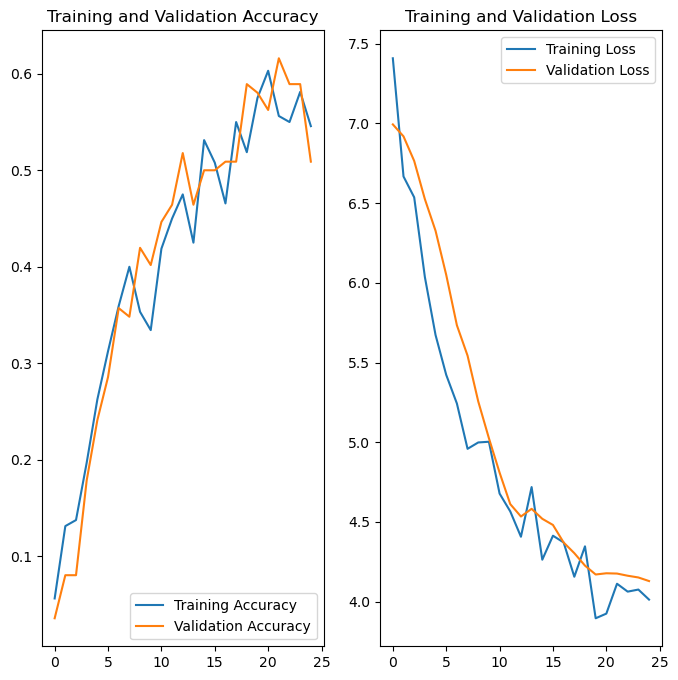

In [62]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

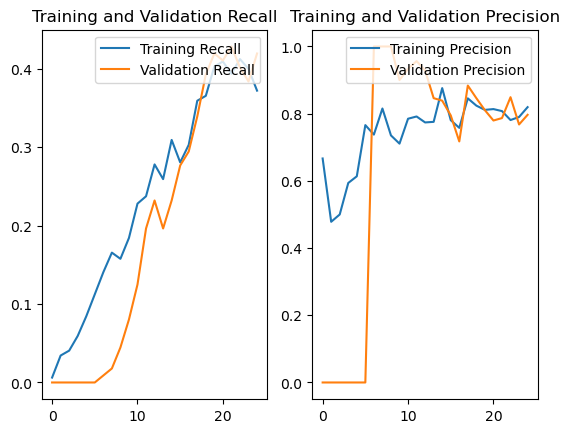

In [63]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, precision, label='Training Precision')
plt.plot(epochs_range, val_precision, label='Validation Precision')
plt.legend(loc='upper right')
plt.title('Training and Validation Precision')

plt.show()

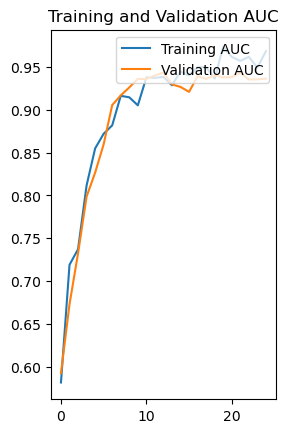

In [64]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC')

plt.show()